# Figure A: Map

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib
from matplotlib.colors import ListedColormap
import xarray as xr 

#plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 12})

import warnings
warnings.filterwarnings("ignore")

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
def compute_air_density(temperature, pressure):
    R_d = 287.05  # J/(kg·K), specific gas constant for dry air
    air_density = pressure / (R_d * temperature)
    return air_density

## Prepare Data

In [4]:
frp =  xr.open_mfdataset("/work/bb1174/user/jason/hamlite/icon_input/data_any_2019/frp/frp_any_2019.nc", engine = 'netcdf4').isel(time = 30)

In [5]:
data_path = "/scratch/b/b381531/experiments/lam_any_2019/run_100/"
ca_fire = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z.nc", engine = 'netcdf4').num_qca
dust_fire = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z.nc", engine = 'netcdf4').num_qdu
h = xr.open_mfdataset(data_path + "lam_any_2019_atm_vgrid_ml.nc", engine = 'netcdf4').zg.mean("ncells")
t_fire = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z.nc", engine = 'netcdf4').ta
p_fire = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z.nc", engine = 'netcdf4').pfull

data_path = "/scratch/b/b381531/experiments/lam_any_2019/run_nofire/"
ca_nofire = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z.nc", engine = 'netcdf4').num_qca
dust_nofire = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z.nc", engine = 'netcdf4').num_qdu
t_nofire = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z.nc", engine = 'netcdf4').ta
p_nofire = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z.nc", engine = 'netcdf4').pfull

h = h.rename({"height_2": "height"})

In [6]:
lon = np.rad2deg(dust_fire.clon)
lat = np.rad2deg(dust_fire.clat)

In [7]:
# For Carbonaceous aerosol
r_ca = 0.16e-6
rho_ca = 1987
volume_ca = (4/3) * np.pi * (r_ca ** 3)  # m³
particle_mass_ca = volume_ca * rho_ca 

# For Dust aerosol
r_du = 0.93e-6
rho_du = 2650
volume_du = (4/3) * np.pi * (r_du ** 3)  # m³
particle_mass_du = volume_du * rho_du 

## Calculate Burden

In [8]:
rho_fire = compute_air_density(t_fire, p_fire)
rho_nofire = compute_air_density(t_nofire, p_nofire)

In [9]:
dz = -h.differentiate("height")

In [10]:
concentration_fire_ca = ca_fire * rho_fire * particle_mass_ca * dz
concentration_nofire_ca = ca_nofire * rho_nofire * particle_mass_ca * dz

concentration_fire_du = dust_fire * rho_fire * particle_mass_du * dz
concentration_nofire_du = dust_nofire * rho_nofire * particle_mass_du * dz

In [11]:
burden_fire_ca = concentration_fire_ca.sum("height") * 1000
burden_nofire_ca = concentration_nofire_ca.sum("height") * 1000

burden_fire_du = concentration_fire_du.sum("height") * 1000 * 1000
burden_nofire_du = concentration_nofire_du.sum("height") * 1000 * 1000

## Plot Panels

In [12]:
# Get the colormaps right
nlevel = 50

base_cmap = plt.cm.get_cmap("gist_heat_r", nlevel)  
colors = base_cmap(np.linspace(0, 1, nlevel))
colors[0] = [1, 1, 1, 0]
colors[1] = [1, 1, 1, 0.5]
colors[2] = [1, 1, 1, 0.25]
custom_cmap_du = ListedColormap(colors)

base_cmap = plt.cm.get_cmap("Greys", nlevel)  
colors = base_cmap(np.linspace(0, 1, nlevel))
colors[0] = [1, 1, 1, 0]
colors[1] = [1, 1, 1, 0.5]
colors[2] = [1, 1, 1, 0.25]
custom_cmap_ca = ListedColormap(colors)

In [13]:
# Some Settings for the plot
times = [40, 80, 96]

maxval_ca = 0.8
maxval_du = 1

levs_ca = np.arange(0, maxval_ca, maxval_ca / nlevel)
levs_du = np.arange(0, maxval_du, maxval_du / nlevel)

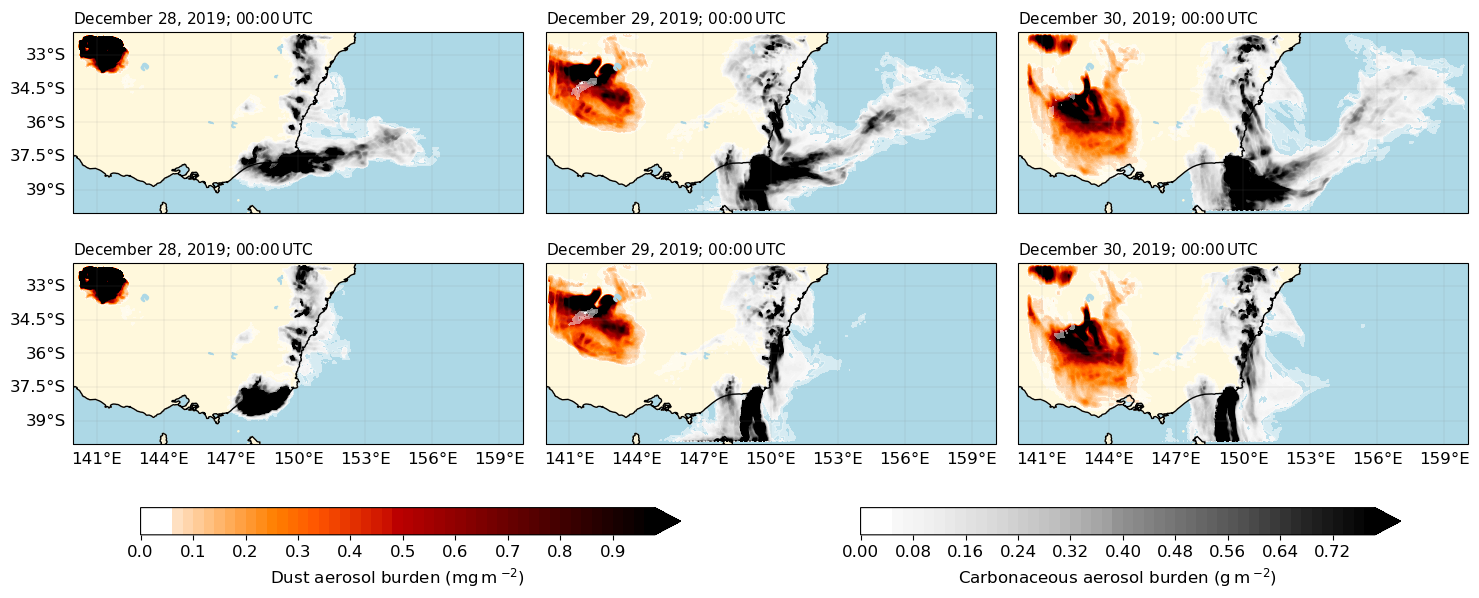

In [14]:
fig, axes = plt.subplots(
    nrows=2, ncols=3,
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(18, 6)
)

utc_string = f"; 00:00$\,$UTC"
titles_top = ["December 28, 2019"+utc_string,"December 29, 2019" + utc_string, "December 30, 2019" + utc_string]
titles_bottom = ["December 28, 2019" + utc_string,"December 29, 2019" + utc_string, "December 30, 2019" + utc_string]

for i, t in enumerate(times):
    # Top row
    ax_top = axes[0, i]
    data_fire_du = burden_fire_du.isel(time=t)
    data_fire_ca = burden_fire_ca.isel(time=t)
    
    c1 = ax_top.tricontourf(lon, lat, data_fire_du, transform=ccrs.PlateCarree(),
                           cmap=custom_cmap_du, levels=levs_du, extend="max")
    c2 = ax_top.tricontourf(lon, lat, data_fire_ca, transform=ccrs.PlateCarree(),
                          cmap=custom_cmap_ca, levels=levs_ca, extend="max")
    
    ax_top.add_feature(cfeature.COASTLINE, linewidth=1)
    ax_top.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax_top.add_feature(cfeature.LAKES, facecolor='lightblue')
    ax_top.add_feature(cfeature.LAND, facecolor='cornsilk')
    ax_top.set_title(titles_top[i], loc="left", fontsize=11)

    # Gridlines and labels
    gl = ax_top.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    if i != 0:
        gl.left_labels = False
    gl.bottom_labels = False

    # Bottom row
    ax_bot = axes[1, i]
    data_nofire_du = burden_nofire_du.isel(time=t)
    data_nofire_ca = burden_nofire_ca.isel(time=t)
    
    ax_bot.tricontourf(lon, lat, data_nofire_du, transform=ccrs.PlateCarree(),
                       cmap=custom_cmap_du, levels=levs_du, extend="max")
    ax_bot.tricontourf(lon, lat, data_nofire_ca, transform=ccrs.PlateCarree(),
                       cmap=custom_cmap_ca, levels=levs_ca, extend="max")
    
    ax_bot.add_feature(cfeature.COASTLINE, linewidth=1)
    ax_bot.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax_bot.add_feature(cfeature.LAKES, facecolor='lightblue')
    #    ax_bot.add_feature(cfeature.RIVERS, facecolor='lightblue')
    ax_bot.add_feature(cfeature.LAND, facecolor='cornsilk')
    ax_bot.set_title(titles_bottom[i], loc="left", fontsize=11)

    # Gridlines and labels
    gl = ax_bot.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    if i != 0:
        gl.left_labels = False
    gl.bottom_labels = True

cbar_ax1 = inset_axes(axes[1, 1], width="120%", height="15%", loc='lower center',
                      bbox_to_anchor=(-0.8, -0.5, 1, 1), bbox_transform=axes[1, 1].transAxes, borderpad=0)

cbar_ax2 = inset_axes(axes[1, 1], width="120%", height="15%", loc='lower center',
                      bbox_to_anchor=(0.8, -0.5, 1, 1), bbox_transform=axes[1, 1].transAxes, borderpad=0)

# Draw colorbars
fig.colorbar(c1, cax=cbar_ax1, orientation="horizontal").set_label("Dust aerosol burden (mg$\,$m$\,^{{-2}}$)")
fig.colorbar(c2, cax=cbar_ax2, orientation="horizontal").set_label("Carbonaceous aerosol burden (g$\,$m$\,^{{-2}}$)")


plt.subplots_adjust(
    hspace=-0,  
    wspace=0.05,  
    right=0.9     
)